# Stock Market Forecasting/ARIMA

***Reference:*** https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima

Here in this notebook we will forecast the stock price of ARCH CAPITAL GROUP using ARIMA model

## What is ARIMA?

Autoregressive Integrated Moving Average (ARIMA) Model converts non-stationary data to stationary data before working on it. It is one of the most popular models to predict linear time series data.

ARIMA model has been used extensively in the field of finance and economics as it is known to be robust, efficient and has a strong potential for short-term share market prediction.

In [50]:
!pip install pmdarima

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y')
stock_data=pd.read_csv("./Dataset/HSBC_Set01/ohlc.csv",index_col='Date',parse_dates=['Date'], date_parser=dateparse)
#stock_data["Date"]=pd.to_datetime(stock_data["Date"], format="%d/%m/%Y")
#stock_data["Date"] = stock_data["Date"].dt.strftime("%Y-%m-%d")
stock_data.head(5)

Visualize the per day closing price of the stock.

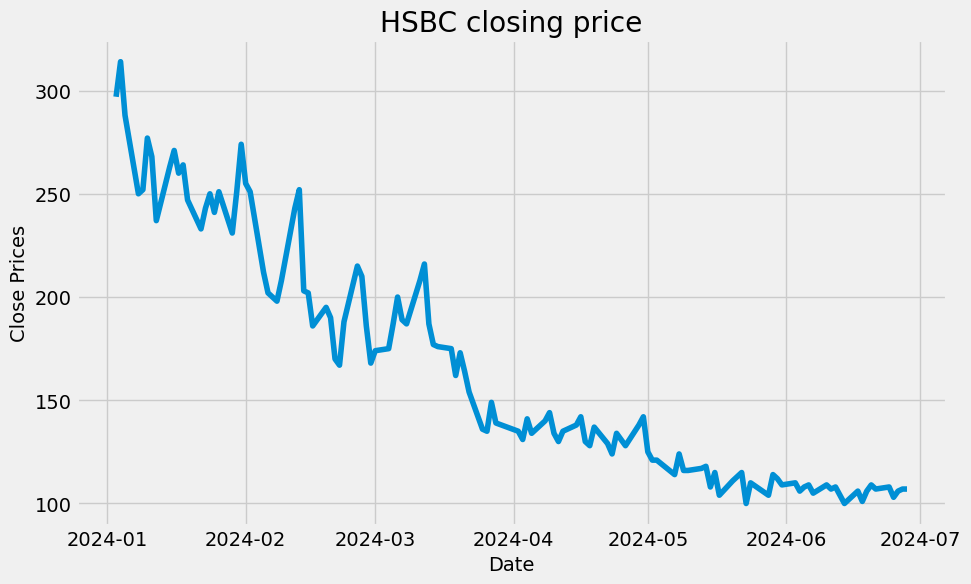

In [53]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('HSBC closing price')
plt.show()

We can also visualize the data in our series through a probability distribution too.

<Axes: ylabel='Density'>

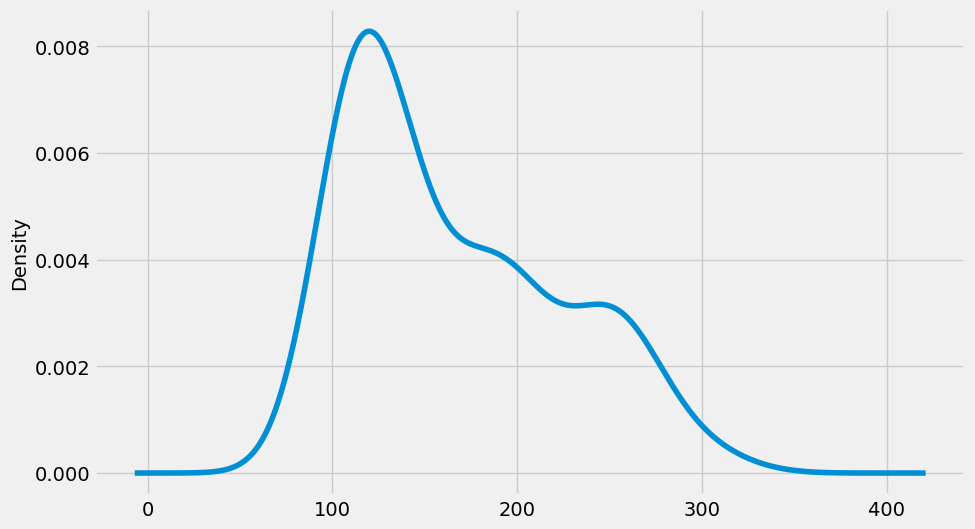

In [54]:
#Distribution of the dataset
df_close=stock_data['Close']
df_close.plot(kind='kde')

Also, a given time series is thought to consist of three systematic components including **level**, **trend**, **seasonality**, and one non-systematic component called **noise**.

These components are defined as follows:

1. Level: The average value in the series.

2. Trend: The increasing or decreasing value in the series.

3. Seasonality: The repeating short-term cycle in the series.

4. Noise: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.

**ADF (Augmented Dickey-Fuller) Test**

The **Dickey-Fuller** test is one of the most popular statistical tests. It can be used to determine the presence of **unit root** in the series, and hence help us understand if the series is **stationary** or not. **The null and alternate hypothesis of this test is**:

**Null Hypothesis**: The series has a unit root (value of a =1)

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be **linear or difference stationary**.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

***Question:*** **What is unit root? Dickey-Fuller test?**

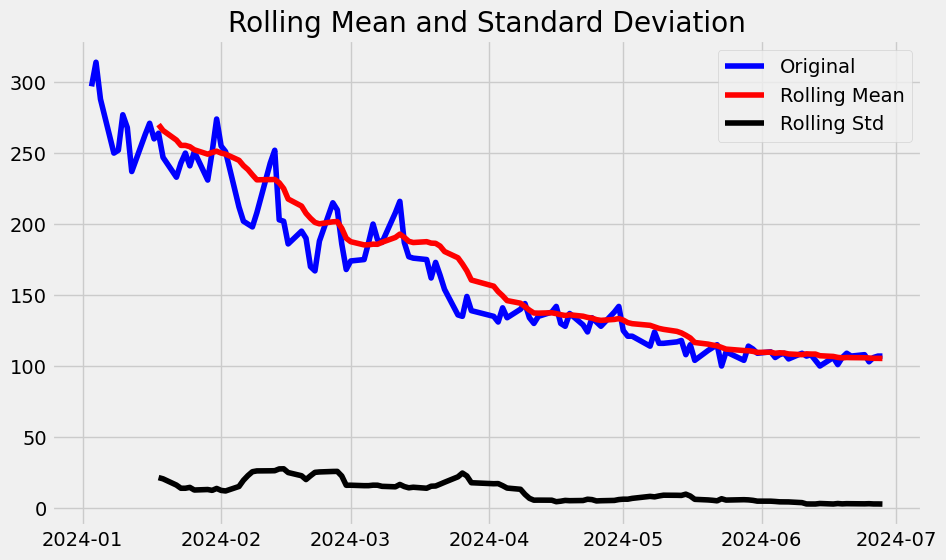

Results of dickey fuller test
Test Statistics                 -1.939472
p-value                          0.313726
No. of lags used                11.000000
Number of observations used    112.000000
critical value (1%)             -3.490131
critical value (5%)             -2.887712
critical value (10%)            -2.580730
dtype: float64


In [55]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)

Through the above graph, we can see the decreasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.


In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.


So let us separate Trend and Seasonality from the time series.

In [122]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. **A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


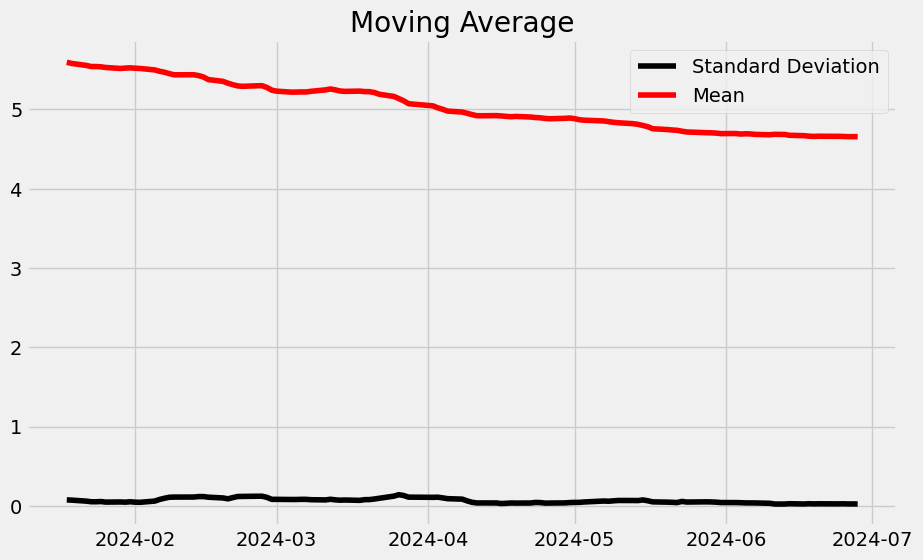

In [57]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
#df_log=df_close.diff()[1:]
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()



Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

TypeError: 'Figure' object is not subscriptable

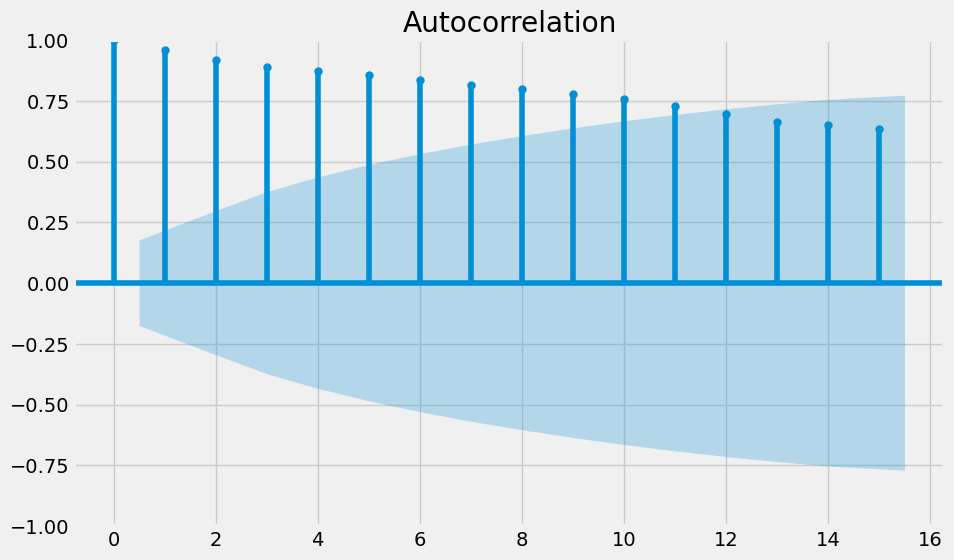

In [58]:
acf_vals =plot_acf(df_log,lags=15)
num_lags=15
plt.bar(range(num_lags), acf_vals[:num_lags])

TypeError: 'Figure' object is not subscriptable

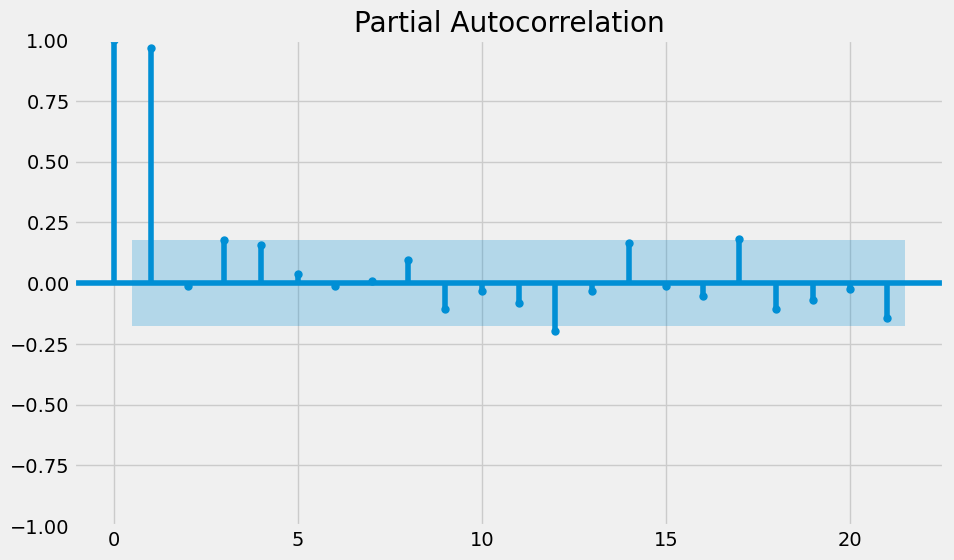

In [66]:
pacf_vals = plot_pacf(df_log)
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

#### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.


The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, **forecast::auto.arima**.


The **auro_arima** function works by conducting differencing tests (i.e., **Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron**) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the **Canova-Hansen** to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-178.479, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-211.877, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=-232.421, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[5]             : AIC=-178.920, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[5]             : AIC=-230.430, Time=1.93 sec
 ARIMA(0,1,1)(0,1,2)[5]             : AIC=-230.428, Time=1.25 sec
 ARIMA(0,1,1)(1,1,0)[5]             : AIC=-215.854, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[5]             : AIC=-229.269, Time=1.62 sec
 ARIMA(0,1,0)(0,1,1)[5]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,2)(0,1,1)[5]             : AIC=inf, Time=2.24 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=-231.351, Time=0.26 sec
 ARIMA(1,1,2)(0,1,1)[5]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,1)(0,1,1)[5] intercept   : AIC=-230.430, Time=1.18 sec

Best model:  ARIMA(0,1,1)(0,1,1)[5]          
Total 

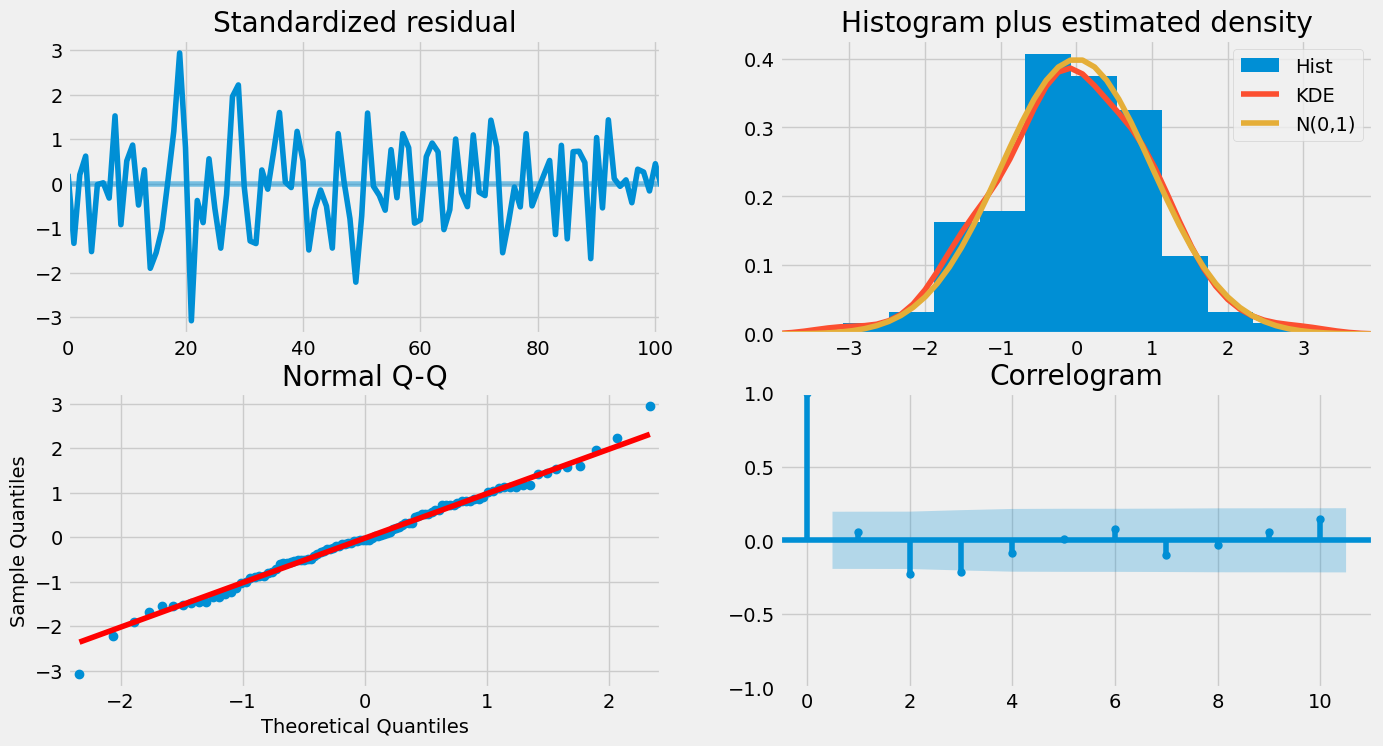

In [119]:
model_autoARIMA = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=15, max_q=15, # maximum p and q
                      m=5,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?


**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


**Top Right**: The density plot suggest normal distribution with mean zero.


**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.


Overall, it seems to be a good fit. Let’s start forecasting the stock prices.


Next, create an ARIMA model with provided optimal parameters p, d and q.

**So the Auto ARIMA model provided the value of p,d, and q as 0, 1 and 0 respectively.**

In [125]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,1), seasonal_order=(0,1,1,5))
fitted = model.fit()  
print(fitted.summary())

                                    SARIMAX Results                                    
Dep. Variable:                           Close   No. Observations:                  108
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 5)   Log Likelihood                 119.211
Date:                         Sat, 22 Apr 2023   AIC                           -232.421
Time:                                 16:38:43   BIC                           -224.546
Sample:                                      0   HQIC                          -229.232
                                         - 108                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2183      0.093     -2.345      0.019      -0.401      -0.036
ma.S.L5       -0.9317      0.136     -6.860      0.000     

### Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

In [110]:
# Forecast
fc= fitted.forecast(steps=len(test_data))  # 95% conf
print(fc)

108    4.690335
109    4.696059
110    4.671894
111    4.684763
112    4.683463
113    4.696599
114    4.703519
115    4.678158
116    4.692779
117    4.691805
118    4.704661
119    4.711067
120    4.686175
Name: predicted_mean, dtype: float64


Plot the results

In [111]:
y_pred=pd.Series(np.array(fc),index=test_data.index)
y_true=test_data
print(np.array(y_pred))
print(np.array(y_true))

[4.69033495 4.69605896 4.67189431 4.6847632  4.68346337 4.69659863
 4.70351861 4.67815841 4.69277877 4.69180493 4.70466132 4.71106694
 4.68617493]
[4.68213123 4.6443909  4.60517019 4.66343909 4.61512052 4.66343909
 4.69134788 4.67282883 4.68213123 4.63472899 4.66343909 4.67282883
 4.67282883]


Date
2024-06-12    4.690335
2024-06-13    4.696059
2024-06-14    4.671894
2024-06-17    4.684763
2024-06-18    4.683463
2024-06-19    4.696599
2024-06-20    4.703519
2024-06-21    4.678158
2024-06-24    4.692779
2024-06-25    4.691805
2024-06-26    4.704661
2024-06-27    4.711067
2024-06-28    4.686175
dtype: float64
RMSE: 0.03951739992302362
MAPE: 0.007081532512374023


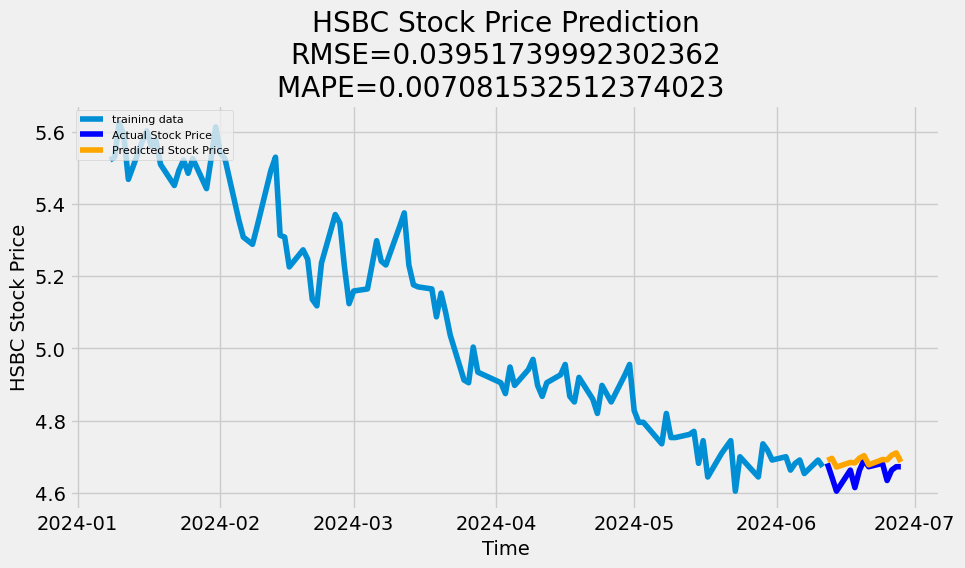

In [112]:
# Make as pandas series
fc_series = pd.Series(np.array(fc), index=test_data.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
print(fc_series)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
rmse = math.sqrt(mean_squared_error(test_data, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))
plt.title('HSBC Stock Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('HSBC Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As you can see our model did quite handsomely. Let us also check the commonly used accuracy metrics to judge forecast results:

In [113]:
# report performance
mse = mean_squared_error(test_data, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0015616248966761868
MAE: 0.03288097082978981
RMSE: 0.03951739992302362
MAPE: 0.007081532512374023


### Around 2.5% MAPE implies the model is about 97.5% accurate in predicting the next 15 observations.